In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

import time
from matplotlib import pyplot as plt

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [90]:
hparams = tf.contrib.training.HParams(
    batch_size=100,
    in_seq_len=61,
    input_dim=5,
    out_seq_len=61,
    output_dim=1,
    num_layers=1,
    neurons_unit=32,
    learning_rate = 0.001,
    lr_decay = 0.99,
    lambd = 1e-6,
    train_split = 0.8,
    val_split = 0.1,
    test_split = 0.1,
    datagen = 'prodn',
    logs_path = '/tmp/tensorflow_logs')

In [213]:
# Load production dataset
if hparams.datagen == 'prodn':
    prodn = pd.read_pickle('../full_6d.pkl').values
    dataset = np.nan_to_num(prodn)[2:]
    mask = np.isfinite(prodn)[2:]

# Load biogas dataset
if hparams.datagen == 'biogas':
    prodn = pd.read_csv('../Data/cr2c_opdata_TMP_PRESSURE_TEMP_WATER_COND_GAS_PH_DPI_LEVEL.csv')
    dataset = prodn['AT305'].values[:10000]
    dataset = [dataset[i : i + hparams.in_seq_len * hparams.input_dim + hparams.out_seq_len + 1] \
               for i in range(0, 10000 - hparams.in_seq_len * hparams.input_dim - hparams.out_seq_len)]
    dataset = np.nan_to_num(dataset)
    np.random.seed(230)
    np.random.shuffle(dataset)
    mask = np.isfinite(dataset)
    
# Create synthetic sine wave data
if hparams.datagen == 'sin':
    dataset = np.zeros((hparams.batch_size, 10 * hparams.in_seq_len))
    dataset[1:,0] = np.random.randn(hparams.batch_size-1)
    for i in range(dataset.shape[1] - 1):
        dataset[:,i+1] = dataset[:,i] + 2 * np.pi / hparams.in_seq_len
    dataset = np.sin(dataset) + 1
    mask = np.ones_like(dataset)

# Reshape data
in_len, out_len, in_dim = hparams.in_seq_len, hparams.out_seq_len, hparams.input_dim
end_pos = in_len * (in_dim - 1) + 1

# x.shape = (n_obs, in_seq_len, input_dim)
x_max, x_var = np.max(dataset[:,:in_len * in_dim], axis=1), np.var(dataset)
x_max[x_max==0] = x_max.max()
x_max = x_max.reshape(-1,1,1)
x = np.array([dataset[:,pos:pos+in_len] for pos in range(0,end_pos,hparams.in_seq_len)])
x = np.rollaxis(x, 0, 3) / x_max

y =   dataset[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis] / x_max
y_mask = mask[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis]

del(dataset, mask)
print(x.shape, y.shape, y_mask.shape)

(14468, 61, 5) (14468, 61, 1) (14468, 61, 1)


In [214]:
dataset = tf.data.Dataset.from_tensor_slices((x.astype(np.float32), y.astype(np.float32), y_mask.astype(np.float32)))
dataset = dataset.batch(hparams.batch_size, drop_remainder=True)

### Define Model

In [72]:
class OneStepAttention(tf.keras.Model):
    def __init__(self, neurons_unit, in_seq_len, name=''):
        super(OneStepAttention, self).__init__()
        self.rpt = tf.keras.layers.RepeatVector(in_seq_len)
        self.cat = tf.keras.layers.Concatenate(axis=-1)
        self.W1 = tf.keras.layers.Dense(neurons_unit, activation = "tanh", name=name + '_W1')
        self.W2 = tf.keras.layers.Dense(1, activation = "relu", name=name + '_W2')
        self.softmax = tf.keras.layers.Activation('softmax', name='attention_weights')
        
    def call(self, hidden_states, prev_state):
    
        # Repeat previous hidden state and concatenate with hidden states
        s_prev = self.rpt(prev_state)
        a0 = self.cat([hidden_states, s_prev])

        # Propagate and calculate softmax activation
        a1 = self.W1(a0)
        a2 = self.W2(a1)
        a2 = tf.keras.backend.squeeze(a2, -1)
        a3 = self.softmax(a2)
        a3 = tf.keras.backend.expand_dims(a3)

        # Compute context vector
        context = tf.keras.layers.Dot(axes = 1)([a3, hidden_states])
        
        return context

In [209]:
def gru(units, name):
    # Use CuDNNGRU is GPU is available (provides a 3x speedup than GRU)
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_activation='sigmoid',
                                        recurrent_initializer='glorot_uniform',
                                        name=name)
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform',
                                   name=name)

In [210]:
class BidirectionalEncDec(tf.keras.Model):
    def __init__(self, neurons_unit, in_seq_len, output_dim):
        super(BidirectionalEncDec, self).__init__()
        self.neurons_unit = neurons_unit
        
        self.encoder = tf.keras.layers.Bidirectional(gru(neurons_unit, 'encoder'))
        self.decoder = gru(neurons_unit, 'decoder')
        self.dec_out = tf.keras.layers.Dense(output_dim, activation='relu', name='decoder_affine')
        self.attention = OneStepAttention(neurons_unit, in_seq_len, 'bi_enc_attn')
    
    def call(self, x, mask, out_seq_len, trace=False):
        """
        Arguments:
            x: Inputs dataset
            out_seq_len: Number of steps to predict
        Returns:
            pred: Model predictions
        """
        if trace: import pdb; pdb.set_trace()
        # Step 1: Run bidirectional encoder
        enc_output, _, _ = self.encoder(x)
        dec_state = tf.zeros((x.shape[0], self.neurons_unit))
        out = tf.slice(x, [0, x.shape[1]-1, x.shape[2]-1], [-1, 1, 1])

        # Step 2: Run decoder for t steps        
        for t in range(out_seq_len):

            # Calculate attention vector, concatenate with raw input
            """
            TODO: Try concatenating enc_output
            """
            mask_t  = tf.slice(mask, [0, t, 0], [-1, 1, -1])
            x_t     = tf.slice(x,    [0, t, 0], [-1, 1, -1])
            context = self.attention(enc_output, dec_state)            
            context = tf.keras.layers.Concatenate(axis=-1)([x_t, out, context])

            # Pass to decoder
            dec_output, dec_state = self.decoder(context, initial_state = [dec_state])
            dec_state = tf.keras.backend.clip(dec_state, -5, 5)
            out = self.dec_out(dec_output) * mask_t

            if t == 0:
                outputs = out
            else:
                outputs = tf.concat([outputs, out], axis=1)

        return outputs

In [211]:
model = BidirectionalEncDec(hparams.neurons_unit, hparams.in_seq_len, hparams.output_dim)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)
inp, target, mask = dataset.make_one_shot_iterator().get_next()

In [ ]:
is_no_nan = True
#while is_no_nan:

for i in range(100):
    for (batch, (inp, target, mask)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            pred = model(inp, mask, hparams.out_seq_len)
            loss = tf.losses.mean_squared_error(labels=target, predictions=pred)
            for var in model.variables:
                loss += tf.reduce_sum(var ** 2) * hparams.lambd

        # update gradients
        variables = model.variables        
        gradients = tape.gradient(loss, variables)
        for grad in gradients:
            if grad != None:
                if np.isnan(np.min(grad)):
                    is_no_nan = False
        if is_no_nan:
            optimizer.apply_gradients(zip(gradients, variables))

        if batch % 10 == 0:
            print(loss)
            plt.plot(np.array(pred[0,:,0]))
            plt.plot(np.array(target[0,:,0]))
            plt.plot(np.array(inp[0,:]), '--')
            plt.show()

            plt.plot(np.sum(pred, axis=0), label='forecast')
            plt.plot(np.sum(target, axis=0), label='target')
            plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
            for i in range(hparams.input_dim):
                plt.plot(np.sum(inp, axis=0)[:,i], '--', label='%i years prior' % (5-i))

            plt.legend()
            plt.show()

In [204]:
for i, p in enumerate(pred):
    if np.isnan(np.min(p)):
        print(i, np.squeeze(p))

92 tf.Tensor(
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]], shape=(61, 1), dtype=float32)


/Documents/venv3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


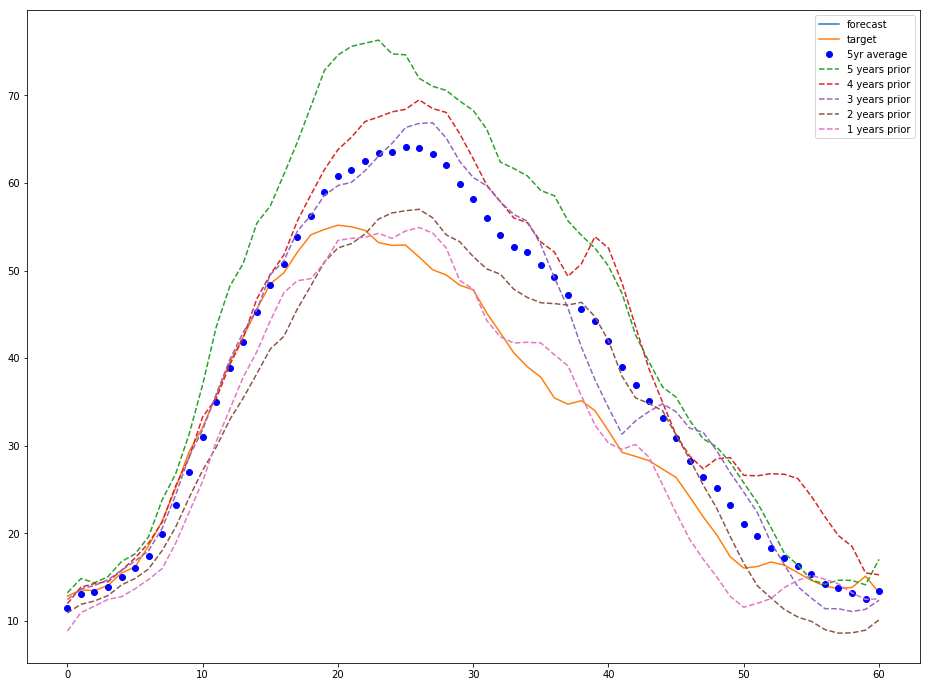

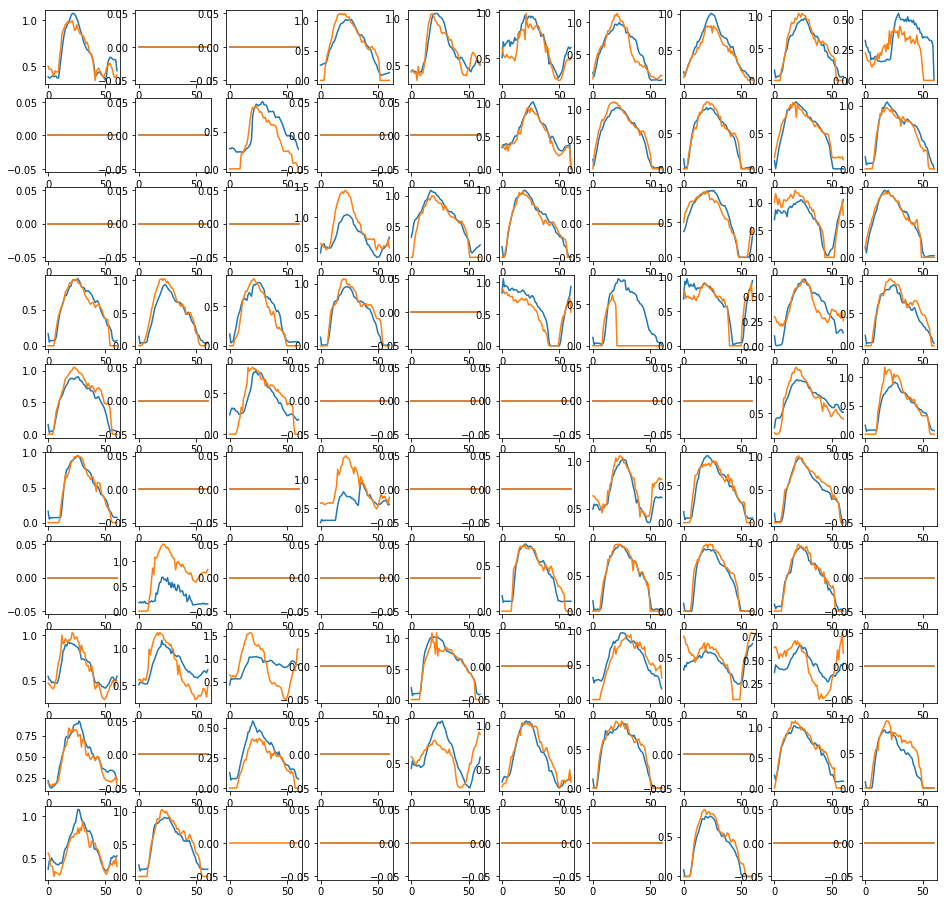

In [205]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(pred, axis=0), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=0)[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(pred[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()